# Spectograms
The studied samples do not rely with a piano, a flute, a violin or a trumpet.

### 2.9 Propose an explanation for why the previous samples do not sound natural

It is just a period of a note, so we can not determine its frequency because of its aperiodicity.

### 2.10 Load, find frequency and play the sound
The files `PianoLa.wav` (Note that this one is `.wav`, it is not a typo), `TrumpetLa.aif`, `ViolinLa.aif` and `FluteLa.aif` correspond to the full recording of the sounds from which the previous period samples have been taken.

In [2]:
# Import necessary libraries
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd

# List of necessary files to load
files = ['./TDSound/Piano.ogg']

# Store sampling frequency as a float
# and amplitudes as an array of each file in:
frequencies = [0] * len(files)
amplitudes = [0] * len(files)

# For each file, store the sampling frequency and the amplitudes
for i in range(len(files)):
    amplitudes[i], frequencies[i] = sf.read(files[i], dtype='float32')   # It loads files and extracts info

# There are 2 channels of sound, we separate them
ch1_amplitudes = [0] * len(files)
ch2_amplitudes = [0] * len(files)
for i in range(len(files)):
    ch1_amplitudes[i] = [amplitudes[i][j][0] for j in range(len(amplitudes[i]))]
    ch2_amplitudes[i] = [amplitudes[i][j][1] for j in range(len(amplitudes[i]))]

# Plot the amplitudes of each file, for ensuring everything is ok
instruments = []    # List of instruments
for i in range(len(files)):
    file = files[i]
    instruments.append(file[10:-4])
    print('Sampling frequency of', instruments[i], 'file:', frequencies[i])

Sampling frequency of Piano file: 44100


For simplicity as there are two channels, we will work just with one of them.

In [3]:
# for i in range(len(ch1_amplitudes)):
#     playing = np.asarray(ch1_amplitudes[i], dtype='float32')
#     sd.play(playing, frequencies[i])
#     status = sd.wait()

#### Is the sound closer to what you expect?

Yes, it is much clearer to distinguish between instruments.

### 2.11 Plot the signal
Note that each array contains two column corresponding to the left and right channel (stereo recording); for simplicity’s sake, we will only study one of them.

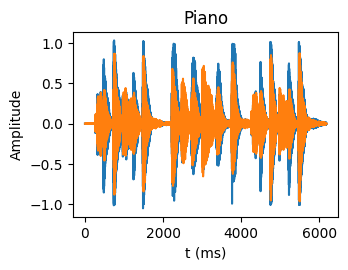

In [4]:
spacing = []
for i in range(len(instruments)):
    spacing.append(1 / frequencies[i])

# Time interval between two values of the sound signal
times = []
for j in range(len(instruments)):
    amplitude = amplitudes[j]
    times.append([i * spacing[j] for i in range(len(amplitude))]) # in seconds

# Subplots of the signals
plt.figure(1)
for i in range(len(instruments)):
    plt.subplot(2, 2, i + 1)
    time = times[i]
    plt.plot([j * 10 ** 3 for j in time], amplitudes[i]) # time in miliseconds
    plt.title(instruments[i])
    plt.ylabel('Amplitude')
    plt.xlabel('t (ms)')
plt.tight_layout()
plt.show()

#### Using the zoom feature interpret the shape of the sound signals.
It depends on the mechanism used, it is easy to distinguish percussion, wind and wire.

#### Show that we can split the evolution of the signal in different phases, and link them to your sensation while listening to the sound.
Initial, middle and final phases.

#### Compare the period of the sound for these different phases.
Piano is the shortest, followed by the violin, and finally the wind instruments lead by the trumpet.

## 2.12 Calculate Fourier transform
Create the frequency axis. Plot the Fourier spectrum. Note that this signal is not periodic, and this calculation is indeed a **Fourier transform** and *no longer a Fourier series* development.

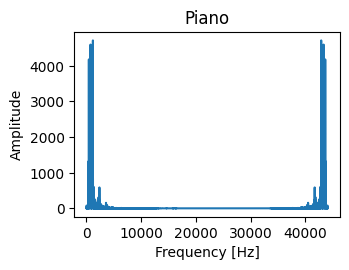

In [5]:
coeffs = []
for i in range(len(instruments)):
    coeffs.append(np.fft.fft(ch1_amplitudes[i]).tolist())  # convert numpy array to list

# Subplots for the absolute value of Fourier coefficients
fourier_freqs = []
plt.figure(2)
for i in range(len(instruments)):
    # Build axis
    time = times[i]
    period = time[-1]   # Signal period, as we know that the signal is 1 period
    signal_freq = 1. / period  # Signal frequency
    fourier_freq = [j * signal_freq for j in range(len(coeffs[i]))]  # Frequency in Fourier space
    fourier_freqs.append(fourier_freq)
    # Plot Fourier spectrum
    plt.subplot(2, 2, i + 1)
    plt.plot(fourier_freqs[i], np.abs(coeffs[i]))
    plt.title(instruments[i])
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
plt.tight_layout()
plt.show()

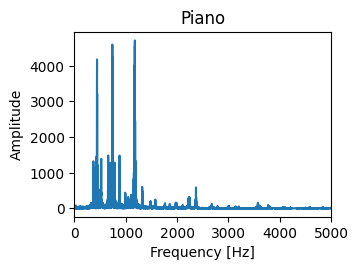

In [6]:
# Zoom
for i in range(len(instruments)):
        # Plot Fourier spectrum
    plt.subplot(2, 2, i + 1)
    plt.plot(fourier_freqs[i], np.abs(coeffs[i]))
    plt.title(instruments[i])
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

### 2.13 Discussion

Discuss on the shape of the spectrum, in particular the following features:
+ the existence of peaks,
  + It is very similar to the previous one.
+ the structures inside each peak,
  + There are several frequencies alltogether.
+ the number of point of each curve.
  + It is greater for the trumpet and violin, and decreases for piano and flute.

When hearing these sounds, our feeling is that the sound evolves,  according to the stages we described in the previous questions.
The **human ear is indeed a mixed detector**: it is sensitive to notes, that are **frequencies** in the Fourier domain, but it can follow the **evolution** of the Fourier components in time.
In order to reproduce this sensation, we will need a **spectro-temporal analysis** using the spectrogram tool.
The principle behind such an analysis is to perform *Fourier transforms on a time windowed version of the signal*, and not on the signal itself.
The time window is then successively shifted and the Fourier transform repeated.
With this operation, we will obtain the evolution in time of the Fourier transform of a sample of the sound.

### 2.14 Separing notes and evolution

Propose an order of magnitude of the brain’s response time.

Let's say `Thum = 0.1` seconds.

 *Below* this value, we will consider that the information content will be in the Fourier domain (interpreted as a **frequency**). *Above* this value, it will correspond to a **time evolution**.
 
 How many points `Nw` (numbers within the window) of the sound signal does it correspond to Fourier domain frequencies?

 To accommodate for the use of power of 2 in the FFT, we will use the `2 ** np.ceil(np.log2(Nw))` function to get an appropriate number of points.

In [7]:
Thum = 0.1      # Human ear response [in seconds] (window size)
fsp = frequencies[0]    # Sampling frequency [in Hz] (the same for all instruments)
real_Nw = Thum * fsp    # Number of points for window size in Fourier Domain
Nw = 2 ** np.ceil(np.log2(real_Nw))  # FFT accomodation for window size
print(Nw)

8192.0


### 2.15 FFT preparation
Using the `Nw` points, and then shift the window by `Nw/4`.

#### To which time duration does that correspond to?


#### How many shifts will we have to do in order to sweep the entire sound trace?


Build a matrix full of zeroes whose lines will store the Fourier spectrum data, and whose columns will correspond to the successive times.

In [8]:
shift = Nw / 4.     # Shift between windows

# Variables for spectrogram
N = []
Nsp = []
for i in range(len(instruments)):
    N.append(len(amplitudes[i]))        # Points in time domain
    Nsp.append(np.floor((N[i] - Nw) / shift))  # Number of spectra
print(Nsp)

timesp = []
for i in range(len(instruments)):
    ts = 1 / frequencies[i]  # Time spacing
    timesp.append([j * shift * ts for j in range(int(Nsp[i]))])  # Time in spectrogram

matrices = []
for i in range(len(instruments)):
    matrices.append(np.zeros((int(Nw), int(Nsp[i]))))

freqsp = []
for i in range(len(instruments)):
    freqsp.append([j * fsp / Nw for j in range(int(Nw))])  # Frequency in spectrogram

[129.0]


### 2.16 FFT

Using a `for` loop, and the notation `A(i:j)`, fill in the previously initialised matrix with the spectrogram of the sound recordings.

In [9]:
# window = np.ones((int(Nw), 1))
# window = np.hanning(Nw)
window = np.hamming(Nw)

# Spectrogram
spec = []
for i in range(len(instruments)):
    matrix = matrices[i]            # Matrix for each instrument
    ch1_amp = ch1_amplitudes[i]     # Amplitude of channel 1
    for j in range(int(Nsp[i])):
        matrix[:, j] = np.fft.fft(ch1_amp[int(shift * j):int(shift * j + Nw)] * window)  # FT for each window
    spec.append(matrix)

C:\Users\propietario\AppData\Local\Temp\ipykernel_18216\1765556934.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[:, j] = np.fft.fft(ch1_amp[int(shift * j):int(shift * j + Nw)] * window)  # FT for each window


### 2.17 Plotting the spectrum Fourier space

The next stage is now to find a way to visualize the content of this spectrogram.
The pcolor function displays data from `A(i,j)` matrices using a colormap for the 𝑧-axis.
Display the spectrogram using this function, and use a decibel scale for the colormap.

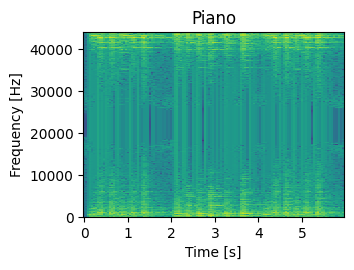

In [10]:
# Plot spectrogram using dB scale and pcolor
plt.figure(3)
for i in range(len(instruments)):
    plt.subplot(2, 2, i + 1)
    plt.pcolor(timesp[i], freqsp[i], 20 * np.log10(np.abs(spec[i])), cmap='viridis')
    plt.title(instruments[i])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [11]:
# Zoom for plot spectrogram using dB scale and pcolor
plt.figure(4)
for i in range(len(instruments)):
    plt.subplot(2, 2, i + 1)
    plt.pcolor(timesp[i], freqsp[i], 20 * np.log10(np.abs(spec[i])), cmap='viridis')
    plt.title(instruments[i])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.ylim(0, 10000)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

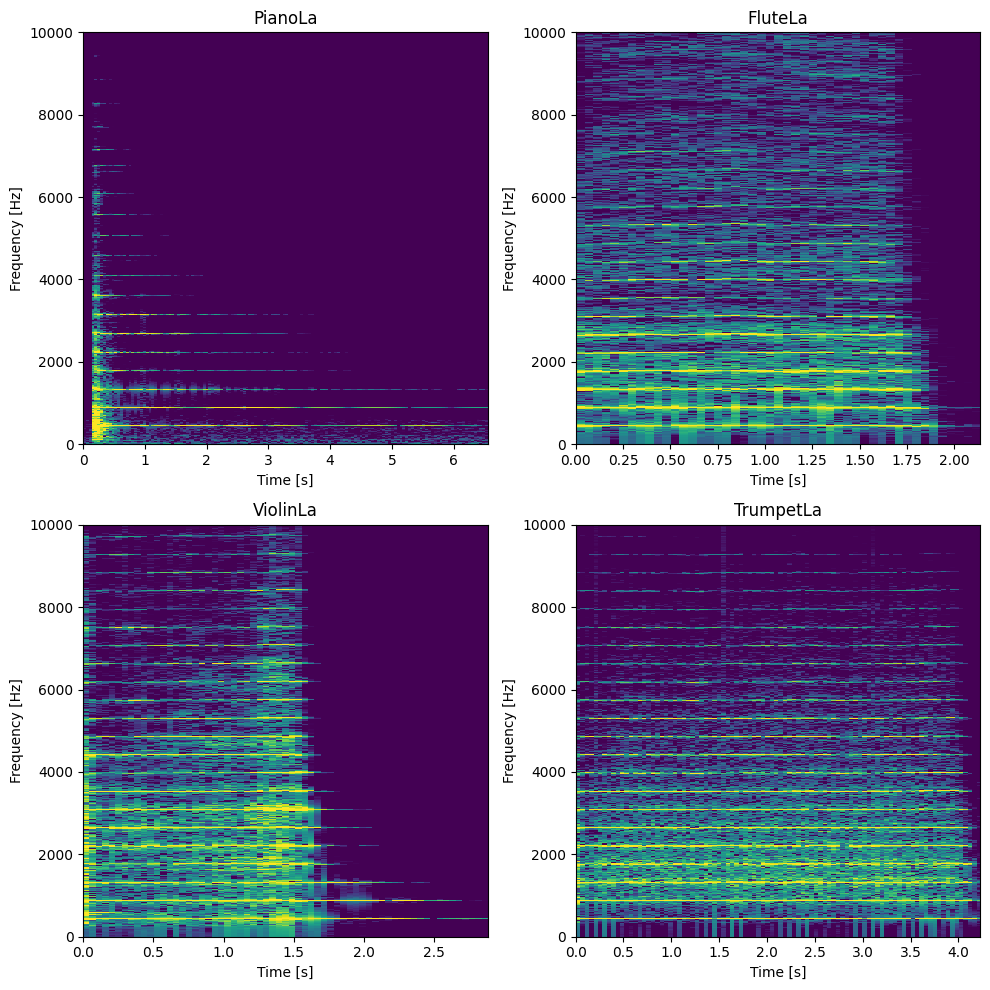

In [ ]:
# Zoom for plot spectrogram using dB scale and pcolor
plt.figure(5)
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=False)     # Create subplots, do not share axes
for i in range(len(instruments)):
    ax = axs[i // 2, i % 2]
    ax.pcolorfast(timesp[i], freqsp[i], 20 * np.log10(np.abs(spec[i])), cmap='viridis', vmin=-40, vmax=5)
    ax.set_title(instruments[i])
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    ax.set_ylim(0, 10000)
plt.tight_layout()
plt.show()

### 2.20 Properties

At this stage, we have obtained a rich and faithful representation of the sounds.
#### What are their main characteristics? Cite some visible differences between the various instruments.

The time for piano holding the frequency is much larger comperd to the other ones (6 vs 2-4 s). If one zoom in the frequencies are a straight line for piano and the other ones are vibrating.

#### Can you link these characteristics to physical properties of the instrument?

Piano is a heavy metallic structure which can stand very well, whereas the other instruments are holded by the musician, although the metallic instrument, as it is the trumpet, performs better.